In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('source.csv')
features = list(df.drop(columns=['data_split','target']).columns)
le = LabelEncoder()
df['target_encoded'] = le.fit_transform(df['target']) # 0 > -1 and 1 > +4

In [3]:
train = df[df['data_split']=='TRAIN']
valid = df[df['data_split']=='VALIDATE']
test = df[df['data_split']=='TEST']

In [4]:
def experiment(features, title):

    # Data Normalization
    scaler = MinMaxScaler().fit(train[features])
    train_ = scaler.transform(train[features])
    valid_ = scaler.transform(valid[features])
    test_ = scaler.transform(test[features])
    x_tr, y_tr = train_, train["target_encoded"]
    x_va, y_va = valid_, valid["target_encoded"]
    x_ts, y_ts = test_, test["target_encoded"]

    # Model Training
    model = LogisticRegression(
        max_iter=1000,
        penalty="l1",
        C=0.01,
        class_weight={0: 1, 1: 6},  # 6x weight for +4
        solver="liblinear",
        random_state=1,
    )
    model.fit(x_tr, y_tr)

    # Predict Probabilitis
    proba_tr = model.predict_proba(x_tr)[:, 1]
    proba_va = model.predict_proba(x_va)[:, 1]
    proba_ts = model.predict_proba(x_ts)[:, 1]

    # Preparing probabilities thresholding
    threshold_list = list()
    train_sum = list()
    valid_sum = list()
    test_sum = list()
    thresholds = np.arange(0.05, 0.99, 0.01)
    for t in thresholds:
        filter_tr = proba_tr >= t
        filter_va = proba_va >= t
        filter_ts = proba_ts >= t
        sum_target_after_tr = train["target"][filter_tr].sum()
        sum_target_after_va = valid["target"][filter_va].sum()
        sum_target_after_ts = test["target"][filter_ts].sum()
        threshold_list.append(t)
        train_sum.append(sum_target_after_tr)
        valid_sum.append(sum_target_after_va)
        test_sum.append(sum_target_after_ts)
    results_df = pd.DataFrame(
        {
            "Threshold": threshold_list,
            "Train Post": train_sum,
            "Valid Post": valid_sum,
            "Test Post": test_sum,
        }
    )
    results_melted = results_df.melt(
        id_vars="Threshold", var_name="Set", value_name="Post"
    )
    plt.figure(figsize=(12, 4))
    plt.title(title)
    sns.lineplot(data=results_melted, x="Threshold", y="Post", hue="Set")
    plt.grid()
    plt.show()
    print(results_df.tail(59))
    return model, x_tr, x_va, x_ts, y_tr, y_va, y_ts

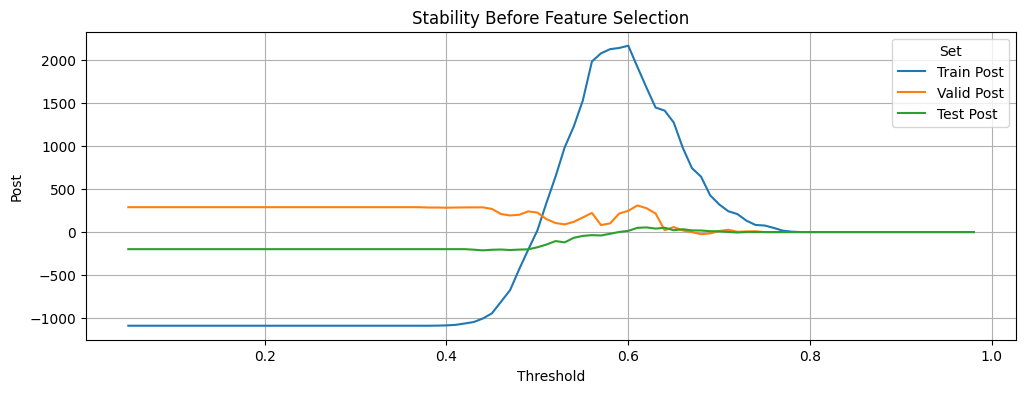

    Threshold  Train Post  Valid Post  Test Post
35       0.40       -1085         283       -199
36       0.41       -1079         285       -199
37       0.42       -1063         286       -199
38       0.43       -1046         287       -205
39       0.44       -1005         287       -213
40       0.45        -945         269       -206
41       0.46        -810         209       -203
42       0.47        -675         193       -209
43       0.48        -432         201       -204
44       0.49        -203         240       -201
45       0.50          19         226       -177
46       0.51         340         150       -145
47       0.52         646         105       -105
48       0.53         984          89       -120
49       0.54        1227         118        -67
50       0.55        1530         170        -45
51       0.56        1983         222        -36
52       0.57        2078          81        -40
53       0.58        2126         101        -20
54       0.59       

In [5]:
# Calling experiment function showing the results on the origianl features
model, x_tr, x_va, x_ts, y_tr, y_va, y_ts = experiment(features=features, title='Stability Before Feature Selection')

In [6]:
# Feature Selection (on training data)
# Returning the top features (those with positive importance)

result = permutation_importance(
    model, x_tr, y_tr, n_repeats=10, random_state=1, scoring="roc_auc", n_jobs=-1
)

perm_imp = pd.DataFrame({"Feature": features, "Importance": result.importances_mean})
# perm_imp.sort_values(by="Importance", ascending=False)
top_features = perm_imp[perm_imp["Importance"] > 0]["Feature"].values
print("Top Features n:", top_features.shape[0])
print("Top Feature names:", top_features)

Top Features n: 67
Top Feature names: ['feature-1' 'feature-3' 'feature-4' 'feature-8' 'feature-19' 'feature-28'
 'feature-34' 'feature-43' 'feature-45' 'feature-47' 'feature-50'
 'feature-65' 'feature-69' 'feature-70' 'feature-123' 'feature-124'
 'feature-127' 'feature-128' 'feature-134' 'feature-152' 'feature-161'
 'feature-193' 'feature-215' 'feature-223' 'feature-234' 'feature-235'
 'feature-252' 'feature-253' 'feature-268' 'feature-277' 'feature-281'
 'feature-296' 'feature-318' 'feature-339' 'feature-373' 'feature-401'
 'feature-410' 'feature-455' 'feature-468' 'feature-472' 'feature-473'
 'feature-479' 'feature-484' 'feature-494' 'feature-510' 'feature-526'
 'feature-531' 'feature-532' 'feature-538' 'feature-548' 'feature-563'
 'feature-565' 'feature-567' 'feature-588' 'feature-593' 'feature-624'
 'feature-632' 'feature-669' 'feature-703' 'feature-704' 'feature-713'
 'feature-721' 'feature-722' 'feature-724' 'feature-733' 'feature-741'
 'feature-750']


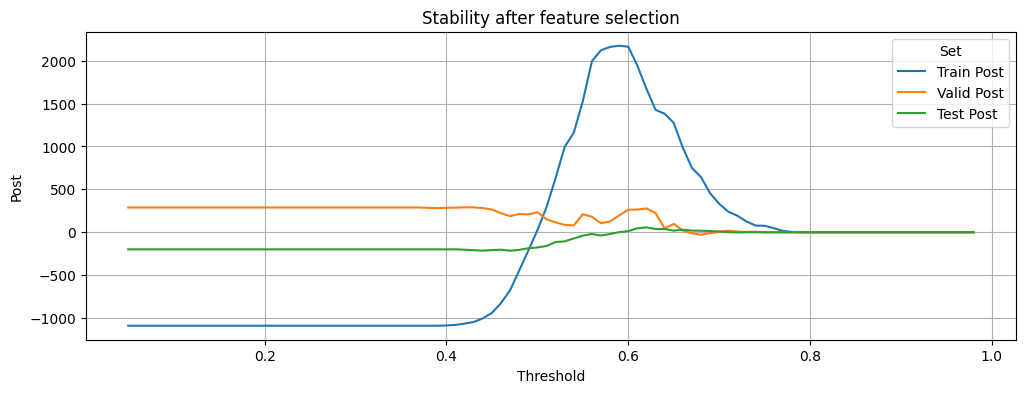

    Threshold  Train Post  Valid Post  Test Post
35       0.40       -1086         285       -199
36       0.41       -1079         287       -199
37       0.42       -1065         291       -203
38       0.43       -1045         290       -209
39       0.44       -1003         282       -214
40       0.45        -939         265       -208
41       0.46        -825         221       -203
42       0.47        -675         188       -215
43       0.48        -445         213       -205
44       0.49        -215         208       -186
45       0.50          24         233       -177
46       0.51         291         152       -160
47       0.52         631         115       -114
48       0.53         994          86       -106
49       0.54        1160          80        -72
50       0.55        1529         211        -39
51       0.56        1995         180        -20
52       0.57        2122         105        -38
53       0.58        2160         127        -20
54       0.59       

In [7]:
# Runing the experiment on the top features
_, _, _, _, _, _, _ = experiment(features=top_features, title='Stability after feature selection')